In [1]:
#Experiment tracking with pytorch

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3905, done.
remote: Counting objects: 100% (1096/1096), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 3905 (delta 986), reused 985 (delta 936), pack-reused 2809
Receiving objects: 100% (3905/3905), 649.58 MiB | 34.60 MiB/s, done.
Resolving deltas: 100% (2277/2277), done.
Updating files: 100% (248/248), done.


In [5]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [7]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
train_dir=image_path/"train"
test_dir=image_path/"test"

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
from torchvision import transforms
manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

from going_modular.going_modular import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=manual_transforms,batch_size=32)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [10]:
#setup pretrained weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms=weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

from going_modular.going_modular import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=automatic_transforms,batch_size=32)

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [11]:
#getting a pretrained model,freeze the base layers and change the classifier layer

In [12]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT

model=torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]


In [13]:
for param in model.features.parameters():
  param.requires_grad=False

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
set_seeds()
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)

In [16]:
from torchinfo import summary
summary(model,(32,3,224,224),
        verbose=0,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [17]:
#train a single model and track results

In [18]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [19]:
#To track experiments we are going to use tensorboard

In [20]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter()
writer

In [21]:
from tqdm.auto import tqdm
from typing import Dict,List,Tuple
from going_modular.going_modular.engine import train_step, test_step


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        #adding a writer
        writer.add_scalars(main_tag="loss",
                           tag_scalar_dict={"train_loss":train_loss,
                                            "test_loss":test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="accuracy",
                           tag_scalar_dict={"train_acc":train_acc,
                                            "test_acc":test_acc},
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))
    writer.close()
    # Return the filled results at the end of the epochs
    return results


In [22]:
set_seeds()
results=train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=5,
              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8038 | train_acc: 0.7461 | test_loss: 0.6723 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6770 | train_acc: 0.8516 | test_loss: 0.6699 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6746 | test_acc: 0.7737


In [23]:
#view our model's results with tensorboard

In [28]:
!tensorboard dev upload --logdir runs \
     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
     --description "Comparing results of different model size, training data amount and training time."

2023-09-17 06:44:34.289822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   SQZJ-XBQW


Upload started and will continue reading any new data as it's added to the logdir.

To stop 

In [29]:
def create_writer(experiment_name:str,
           model_name:str,
           extra:str=None):
  from datetime import datetime
  import os
  timestamp=datetime.now().strftime("%Y-%m-%d")
  if extra:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
  return SummaryWriter(log_dir=log_dir)

In [30]:
example_writer=create_writer(experiment_name="data_10_percent",model_name="effnetb0",extra="5_epochs")
example_writer

[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_10_percent/effnetb0/5_epochs...


In [31]:
from tqdm.auto import tqdm
from typing import Dict,List,Tuple
from going_modular.going_modular.engine import train_step, test_step


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer:torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:

        #adding a writer
          writer.add_scalars(main_tag="loss",
                            tag_scalar_dict={"train_loss":train_loss,
                                              "test_loss":test_loss},
                            global_step=epoch)
          writer.add_scalars(main_tag="accuracy",
                            tag_scalar_dict={"train_acc":train_acc,
                                              "test_acc":test_acc},
                            global_step=epoch)
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32,3,224,224).to(device))
          writer.close()
        else:
          pass
    # Return the filled results at the end of the epochs
    return results

In [32]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [33]:
train_dir_10_percent=data_10_percent_path/"train"
train_dir_20_percent=data_20_percent_path/"test"

test_dir=data_10_percent_path/"test"

In [34]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
simple_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [35]:
BATCH_SIZE=32

train_data_loader_10_percent,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                       test_dir=test_dir,
                                                                                       transform=simple_transform,
                                                                                       batch_size=BATCH_SIZE)
train_data_loader_20_percent,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                       test_dir=test_dir,
                                                                                       transform=simple_transform,
                                                                                       batch_size=BATCH_SIZE)

In [36]:
print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_data_loader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_data_loader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(test_dataloader)}")
print(f"Number of classes: {len(class_names)},class names:{class_names}")



Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 10% train data: 5
Number of batches of size 32 in 10% train data: 3
Number of classes: 3,class names:['pizza', 'steak', 'sushi']


In [37]:
import torchvision
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)
effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 255MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [46]:
import torchvision
from torch import nn
OUT_FEATURES=len(class_names)
def create_effnetb0():
  weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model=torchvision.models.efficientnet_b0(weights=weights).to(device)

  for params in model.parameters():
    params.requires_grad=False

  set_seeds()
  model.classifier=nn.Sequential(
      nn.Dropout(p=0.2,inplace=True),
      nn.Linear(in_features=1280,out_features=OUT_FEATURES)
  ).to(device)
  model.name="efficientb0"
  print(f"[INFO] Created new {model.name} model....")
  return model

In [47]:
created_model_test=create_effnetb0()

[INFO] Created new efficientb0 model....


In [48]:
from torchinfo import summary
summary(created_model_test,(32,3,224,224),
        verbose=0,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [51]:
def create_effnetb2():
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model=torchvision.models.efficientnet_b2(weights=weights).to(device)

  for params in model.parameters():
    params.requires_grad=False

  set_seeds()
  model.classifier=nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,out_features=OUT_FEATURES)
  ).to(device)
  model.name="efficientb2"
  print(f"[INFO] Created new {model.name} model....")
  return model

In [52]:
created_model_test=create_effnetb2()

[INFO] Created new efficientb2 model....


In [53]:
from torchinfo import summary
summary(created_model_test,(32,3,224,224),
        verbose=0,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [54]:
#cerate a peoch list
num_epochs=[5,10]

#create models list(need to create a new model for each experiment)
models=["effnetb0","effnetb2"]

#create a dataloaders dictionary with traindataloaders
train_dataloaders={"data_10_percent":train_data_loader_10_percent,
                   "data_20_percent":train_data_loader_20_percent}

In [57]:
%%time
from going_modular.going_modular.utils import save_model
#set seeds
set_seeds()

#keep track of experiment numbers
experiment_number=0
#loopthrough each dataloader
for dataloader_name,train_dataloader in train_dataloaders.items():
  #llop through number of epochs
  for epochs in num_epochs:
    #loop through each model and create new model instance
    for model_name in models:

      #print out information
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      #select and create model
      if model_name=="effnetb0":
        model=create_effnetb0()
      else:
        model=create_effnetb2()

      #setup loss and optimizer function
      loss_fn=nn.CrossEntropyLoss()
      optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

      #train model with target dataloader and track functions
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,model_name=model_name,extra=f"{epochs}_epochs"))
      #save model to file
      save_filepath=f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new efficientb0 model....
[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9280 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9398 | train_acc: 0.5391 | test_loss: 0.8326 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7280 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7013 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5818 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new efficientb2 model....
[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0903 | train_acc: 0.3906 | test_loss: 0.9549 | test_acc: 0.6600
Epoch: 2 | train_loss: 0.8865 | train_acc: 0.6562 | test_loss: 0.8967 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.8412 | train_acc: 0.6562 | test_loss: 0.7889 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.6971 | train_acc: 0.8516 | test_loss: 0.6762 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7068 | train_acc: 0.7305 | test_loss: 0.6357 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new efficientb0 model....
[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9280 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9398 | train_acc: 0.5391 | test_loss: 0.8326 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7280 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7013 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5818 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5409 | train_acc: 0.8750 | test_loss: 0.5932 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6397 | train_acc: 0.7031 | test_loss: 0.5925 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5071 | train_acc: 0.8008 | test_loss: 0.5386 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4676 | train_acc: 0.9219 | test_loss: 0.5325 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5791 | train_acc: 0.7344 | test_loss: 0.4894 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0903 | train_acc: 0.3906 | test_loss: 0.9549 | test_acc: 0.6600
Epoch: 2 | train_loss: 0.8865 | train_acc: 0.6562 | test_loss: 0.8967 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.8412 | train_acc: 0.6562 | test_loss: 0.7889 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.6971 | train_acc: 0.8516 | test_loss: 0.6762 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7068 | train_acc: 0.7305 | test_loss: 0.6357 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5829 | train_acc: 0.9023 | test_loss: 0.6463 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6000 | train_acc: 0.8125 | test_loss: 0.5898 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5325 | train_acc: 0.8164 | test_loss: 0.5853 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.4866 | train_acc: 0.8164 | test_loss: 0.5450 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.5146 | train_acc: 0.8086 | test_loss: 0.5342 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0353 | train_acc: 0.4523 | test_loss: 0.9849 | test_acc: 0.4991
Epoch: 2 | train_loss: 0.8675 | train_acc: 0.7267 | test_loss: 0.8076 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.7159 | train_acc: 0.8415 | test_loss: 0.6864 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6354 | train_acc: 0.8852 | test_loss: 0.6125 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.5330 | train_acc: 0.9034 | test_loss: 0.5816 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new efficientb2 model....
[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0667 | train_acc: 0.3739 | test_loss: 0.9979 | test_acc: 0.4858
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.5875 | test_loss: 0.8833 | test_acc: 0.7216
Epoch: 3 | train_loss: 0.8022 | train_acc: 0.7619 | test_loss: 0.7775 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.6991 | train_acc: 0.8756 | test_loss: 0.7124 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6157 | train_acc: 0.8875 | test_loss: 0.6831 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new efficientb0 model....
[INFO] Created SummaryWriter, saving to: runs/2023-09-17/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0353 | train_acc: 0.4523 | test_loss: 0.9849 | test_acc: 0.4991
Epoch: 2 | train_loss: 0.8675 | train_acc: 0.7267 | test_loss: 0.8076 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.7159 | train_acc: 0.8415 | test_loss: 0.6864 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6354 | train_acc: 0.8852 | test_loss: 0.6125 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.5330 | train_acc: 0.9034 | test_loss: 0.5816 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.4792 | train_acc: 0.9187 | test_loss: 0.5602 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.4184 | train_acc: 0.9534 | test_loss: 0.5240 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.3829 | train_acc: 0.9477 | test_loss: 0.4876 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3361 | train_acc: 0.9472 | test_loss: 0.4507 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3263 | train_acc: 0.9477 | test_loss: 0.4317 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0667 | train_acc: 0.3739 | test_loss: 0.9979 | test_acc: 0.4858
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.5875 | test_loss: 0.8833 | test_acc: 0.7216
Epoch: 3 | train_loss: 0.8022 | train_acc: 0.7619 | test_loss: 0.7775 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.6991 | train_acc: 0.8756 | test_loss: 0.7124 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6157 | train_acc: 0.8875 | test_loss: 0.6831 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.5471 | train_acc: 0.9250 | test_loss: 0.6606 | test_acc: 0.8258
Epoch: 7 | train_loss: 0.4813 | train_acc: 0.9625 | test_loss: 0.6239 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.4353 | train_acc: 0.9256 | test_loss: 0.5826 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.3734 | train_acc: 0.9750 | test_loss: 0.5396 | test_acc: 0.9271
Epoch: 10 | train_loss: 0.3571 | train_acc: 0.9597 | test_loss: 0.5143 | test_acc: 0.9271
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [61]:
!tensorboard dev upload --logdir runs \
    --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
    --description "Comparing results of different model size, training data amount and training time."\
    --one_shot

2023-09-17 07:44:35.249914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/MPXyYNJmQnms5baPOR3RVw/

[2023-09-17T07:44:38] Started scanning logdir.
E0917 07:44:39.507380 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:40.426776 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:41.412362 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:42.389774 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:43.497459 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:44.395488 136953862861440 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0917 07:44:45.424041 136953862861440 uploader.py:1122] Attempted to re-upload existing 

In [63]:
best_model_path="models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model=create_effnetb2()

#load the best saved model state dict
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new efficientb2 model....


<All keys matched successfully>

In [64]:
from pathlib import Path
effnetb2_model_size=Path(best_model_path).stat().st_size//(1024*1024)
print(f"EfficientNetB2 feature extractor model size:{effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size:29 MB


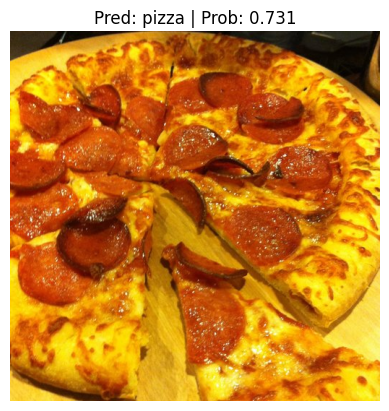

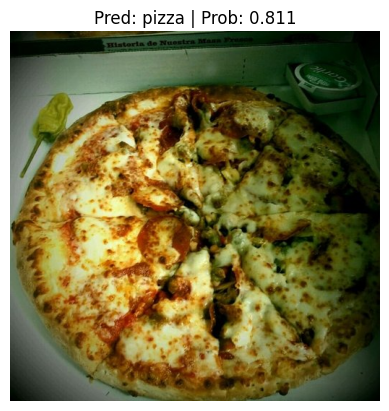

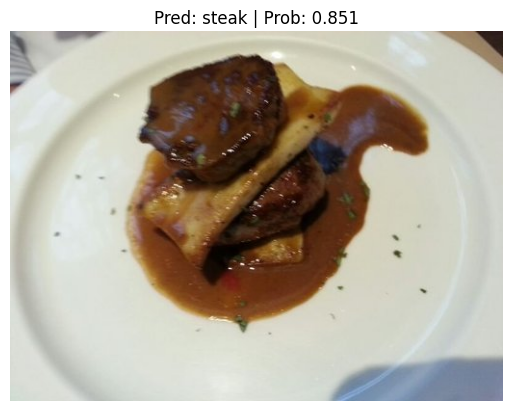

In [65]:
#import function
from going_modular.going_modular.predictions import pred_and_plot_image
import random
num_images_to_plot=3
test_image_path_list=list(Path(data_20_percent_path/"test").glob("*/*.jpg"))
test_image_path_sample=random.sample(test_image_path_list,k=num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,image_path=image_path,class_names=class_names,image_size=(224,224))

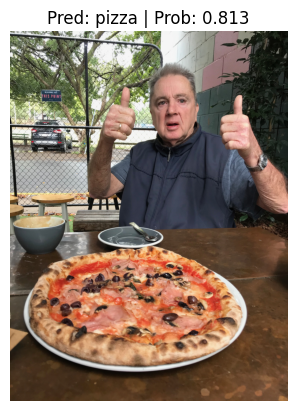

In [66]:
import requests
custom_image_path=Path("data/04-pizza-dad.jpeg")
if not custom_image_path.is_file():
    with open(custom_image_path,"wb") as f:
        request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)